In [1]:
from pandas import read_csv, set_option, concat, DataFrame, cut
from matplotlib.pyplot import subplots, show
from seaborn import pairplot, stripplot, heatmap, boxplot
from math import ceil
from numpy import arange, mean, round

# For dealing with imbalanced class distribution
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

from sklearn.preprocessing import OneHotEncoder, RobustScaler, StandardScaler
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.metrics import recall_score, precision_score, roc_curve, roc_auc_score

from sklearn.svm import SVC  #, LinearSVC
# from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
# from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier


Online Payments Fraud Detection Dataset<br>
https://www.kaggle.com/datasets/rupakroy/online-payments-fraud-detection-dataset/data<br>

Features<br>

Categorical<br>
type:     online transaction type (cash out, payment, cash in, transfer, debit)<br>
nameOrig: customer initiating the transaction<br>
nameDest: recipient of the transaction<br>

Numerical<br>
step:           represents a unit of time (1 step = 1 hour)<br>
amount:         transaction amount<br>
oldbalanceOrig: balance before the transaction<br>
newbalanceOrig: balance after the transaction<br>
oldbalanceDest: initial balance of recipient before the transaction<br>
newbalanceDest: the new balance of recipient after the transaction<br>
isFraud:        fraud class (0,1)


In [2]:
set_option('display.max_columns', None)  # Force Pandas to show/display all columns of dataframe

fraud_df = read_csv('fraud.csv')

print(fraud_df.shape)
print(fraud_df.columns)
fraud_df.head()

(6362620, 11)
Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


This dataset is very big - over 6.3 x10^6 (6.3e+06) rows! My laptop took noticeably longer to load the dataset and output the .head()!<br>
The description of 'step' (1-743), other than a unit of time, is otherwise unclear. Given 743 steps/hours = 31 days/1 month,<br>
I am assuming that it reflects the period over which the data was collected and it started at midnight, so 1 means the data was collected between 00:00 - 01:00,<br>
2 means the data was collected between 01:00 - 02:00, and so on.

In [3]:
# Tidy up dataset

# Drop the extra feature 'isFlaggedFraud' which is not described as being pert of the dataset
fraud_df = fraud_df.drop('isFlaggedFraud', axis=1)

# Correct the inconsistent nomenclature: 'oldbalanceOrg' to 'oldbalanceOrig'
fraud_df = fraud_df.rename(columns={'oldbalanceOrg': 'oldbalanceOrig'})

# Verify changes
print(fraud_df.shape)
print(fraud_df.columns)
fraud_df.head()

(6362620, 10)
Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrig',
       'newbalanceOrig', 'nameDest', 'oldbalanceDest', 'newbalanceDest',
       'isFraud'],
      dtype='object')


,step,type,amount,nameOrig,oldbalanceOrig,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0


In [4]:
fraud_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 10 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrig  float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
dtypes: float64(5), int64(2), object(3)
memory usage: 485.4+ MB


In [5]:
fraud_df.describe()

,step,amount,oldbalanceOrig,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00


In [6]:
fraud_df.duplicated().sum()

np.int64(0)

No row duplication.

In [7]:
fraud_df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrig    0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
dtype: int64

No apparent missing/null values.

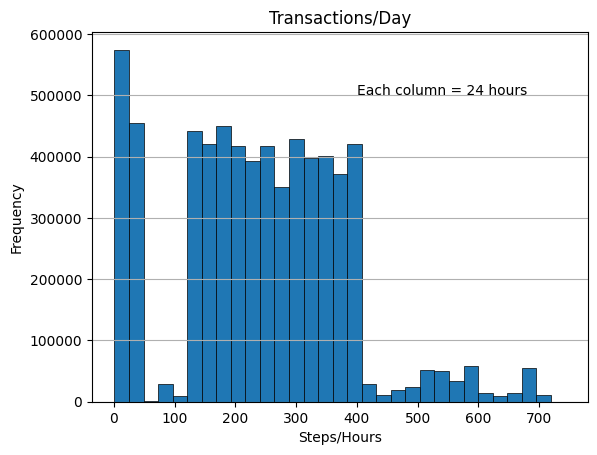

In [8]:
# Inspect 'step' feature
# Sort data collection by day

line_width = 0.5
edge_colour = 'k'

fig, ax = subplots()

n_bins = ceil(fraud_df['step'].max() / 24)  # Set number of bins to number of days over data collection period (31); 24 hours per day
# print(n_bins)

ax.hist(x=fraud_df['step'], bins=n_bins, linewidth=line_width, edgecolor=edge_colour)
ax.grid(visible=True, axis='y')
ax.set_xlabel('Steps/Hours')
ax.set_ylabel('Frequency')
ax.set_title('Transactions/Day')
ax.text(x=400, y=500000, s='Each column = 24 hours')

show()

# Feature engineering

In [9]:
# for i in range(0,31,1):
    # fraud_df[((fraud_df['step'] > i*24) & (fraud_df['step'] <= (i+1)*24))]
    # fraud_df['Day'] = i+1

# fraud_df.head()

In [10]:
# Group 'step' into days: each 24 steps/hours = a day; steps 1-24 = day 1, steps 25-48 = day 2, etc
# Create the bins (step/hours) and labels (days) required for Pandas cut(). len(bins) must be 1 more than len(labels)

hours = []  # bins
for i in range(0,32,1):
    x = i*24
    hours.append(x)
print(len(hours))
print(hours)

days = []  # labels
for i in range(1,32,1):
    days.append(i)
print(len(days))
print(days)

32
[0, 24, 48, 72, 96, 120, 144, 168, 192, 216, 240, 264, 288, 312, 336, 360, 384, 408, 432, 456, 480, 504, 528, 552, 576, 600, 624, 648, 672, 696, 720, 744]
31
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]


In [11]:
# Add new feature 'Day' with step/hours binned into days
fraud_df['Day'] = cut(fraud_df['step'], bins=hours, labels=days)

In [12]:
# Verify outcome of cut()
print(fraud_df['Day'].unique())
print(fraud_df.head())
print(fraud_df.tail())
fraud_df.sample(20)

[1, 2, 3, 4, 5, ..., 27, 28, 29, 30, 31]
Length: 31
Categories (31, int64): [1 < 2 < 3 < 4 ... 28 < 29 < 30 < 31]
   step      type    amount     nameOrig  oldbalanceOrig  newbalanceOrig  \
0     1   PAYMENT   9839.64  C1231006815        170136.0       160296.36   
1     1   PAYMENT   1864.28  C1666544295         21249.0        19384.72   
2     1  TRANSFER    181.00  C1305486145           181.0            0.00   
3     1  CASH_OUT    181.00   C840083671           181.0            0.00   
4     1   PAYMENT  11668.14  C2048537720         41554.0        29885.86   

      nameDest  oldbalanceDest  newbalanceDest  isFraud Day  
0  M1979787155             0.0             0.0        0   1  
1  M2044282225             0.0             0.0        0   1  
2   C553264065             0.0             0.0        1   1  
3    C38997010         21182.0             0.0        1   1  
4  M1230701703             0.0             0.0        0   1  
         step      type      amount     nameOrig  oldbala

,step,type,amount,nameOrig,oldbalanceOrig,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,Day
6085743,522,CASH_OUT,309003.74,C365587145,25140.00,0.00,C759362791,0.00,309003.74,0,22
3749749,279,PAYMENT,5457.86,C571260176,0.00,0.00,M1427215992,0.00,0.00,0,12
4841149,347,CASH_IN,84255.73,C1153187363,2061724.43,2145980.17,C802375233,249281.72,165025.98,0,15
306419,16,CASH_OUT,379816.42,C634924004,2485.00,0.00,C1733257496,603023.51,982839.93,0,1
4349369,309,CASH_IN,208043.44,C1372061250,5197126.85,5405170.29,C935137504,236016.65,27973.21,0,13
2792787,215,PAYMENT,4566.01,C388913407,0.00,0.00,M490989052,0.00,0.00,0,9
1943650,177,CASH_OUT,171119.38,C1171458439,20727.00,0.00,C1687721303,891118.04,1062237.42,0,8
4409606,322,PAYMENT,27163.89,C695771512,100101.00,72937.11,M1603993272,0.00,0.00,0,14
3309033,252,CASH_IN,137309.90,C2076627901,117623.00,254932.90,C711185054,90462.79,0.00,0,11
67842,9,CASH_IN,3918.68,C1891910832,12042507.83,12046426.51,C2131646292,4348921.85,5916456.00,0,1


In [13]:
# Verify Day value at junction of 24-25 step/hour
fraud_df.iloc[574252:574258]

,step,type,amount,nameOrig,oldbalanceOrig,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,Day
574252,24,PAYMENT,5640.33,C1233282643,26421.0,20780.67,M1853051515,0.00,0.00,0,1
574253,24,TRANSFER,820545.98,C192409957,42267.0,0.00,C1154280433,6673075.17,7493621.15,0,1
574254,24,PAYMENT,3384.92,C1518699626,46771.0,43386.08,M7324055,0.00,0.00,0,1
574255,25,PAYMENT,19161.18,C1954261867,1589.0,0.00,M1085509720,0.00,0.00,0,2
574256,25,PAYMENT,7725.76,C912521968,189169.0,181443.24,M1216280274,0.00,0.00,0,2
574257,25,PAYMENT,7655.50,C1635204165,127302.0,119646.50,M1025130851,0.00,0.00,0,2


All looking good.

In [14]:
# Can now drop 'step' feature
fraud_df.drop('step', axis=1, inplace=True)

# Convert 'Day' dtype to int
fraud_df['Day'] = fraud_df['Day'].astype('int')

# Verify changes
fraud_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 10 columns):
 #   Column          Dtype  
---  ------          -----  
 0   type            object 
 1   amount          float64
 2   nameOrig        object 
 3   oldbalanceOrig  float64
 4   newbalanceOrig  float64
 5   nameDest        object 
 6   oldbalanceDest  float64
 7   newbalanceDest  float64
 8   isFraud         int64  
 9   Day             int64  
dtypes: float64(5), int64(2), object(3)
memory usage: 485.4+ MB


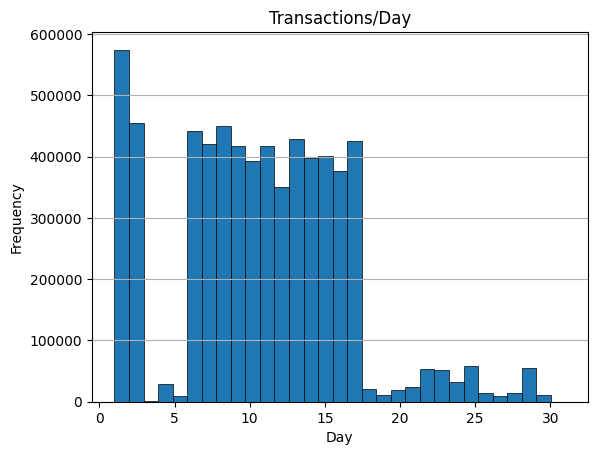

In [15]:
# Inspect new 'Day' feature

line_width = 0.5
edge_colour = 'k'

fig, ax = subplots()

n_bins = fraud_df['Day'].nunique()  # Set number of bins to number of days over data collection period; 24 hours per day
# print(n_bins)

ax.hist(x=fraud_df['Day'], bins=n_bins, linewidth=line_width, edgecolor=edge_colour)
ax.grid(visible=True, axis='y')
ax.set_xlabel('Day')
ax.set_ylabel('Frequency')
ax.set_title('Transactions/Day')
# ax.text(x=400, y=500000, s='Each column = 1 day/24 hours')

show()

In [16]:
# Check why day 31 isn't appearing

(fraud_df['Day'] == 31).value_counts()

Day
False    6362348
True         272
Name: count, dtype: int64

Day 31 has the lowest counts at 272 which, given the scale, is not visible.

Days 1-2 & 6-17 had many transactions.<br>
Days 3 & 31 have the lowest transactions (see below).

/Users/timbo/Library/Python/3.12/lib/python/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


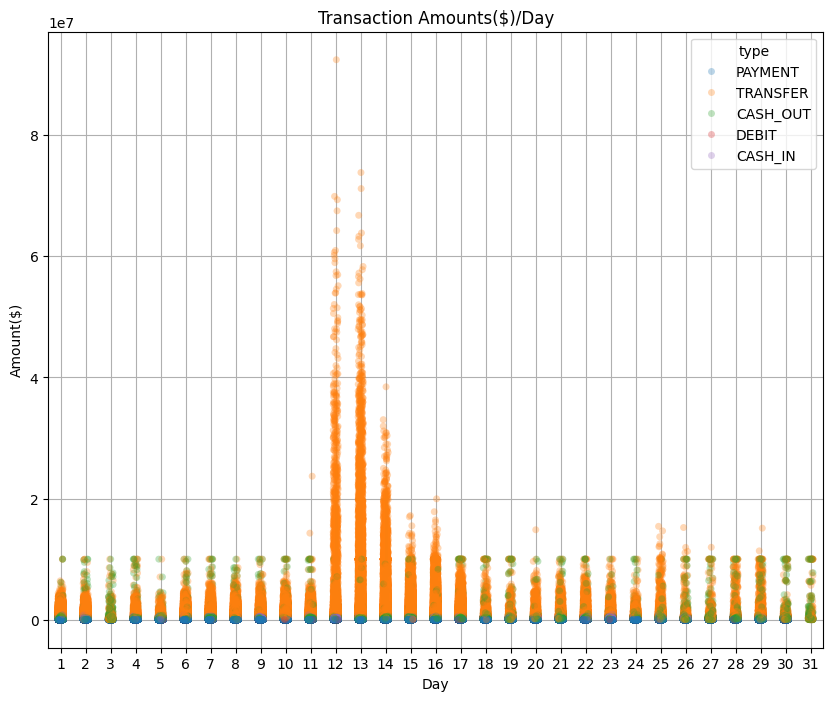

In [17]:
# Strip plot (Seaborn) of transaction amounts/day colour-coded by type

fig, ax = subplots(figsize=(10,8))

stripplot(x=fraud_df['Day'], y=fraud_df['amount'], hue=fraud_df['type'], jitter=True, alpha=0.3)
ax.set_title('Transaction Amounts($)/Day')
ax.set_ylabel('Amount($)')
ax.grid(True)

show();

The transaction amounts ($) peaked on days 12-14 of the data collection period.<br>
Days 3 & 31 are mainly of the transaction types 'cash out' with some 'transfer'.

/Users/timbo/Library/Python/3.12/lib/python/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


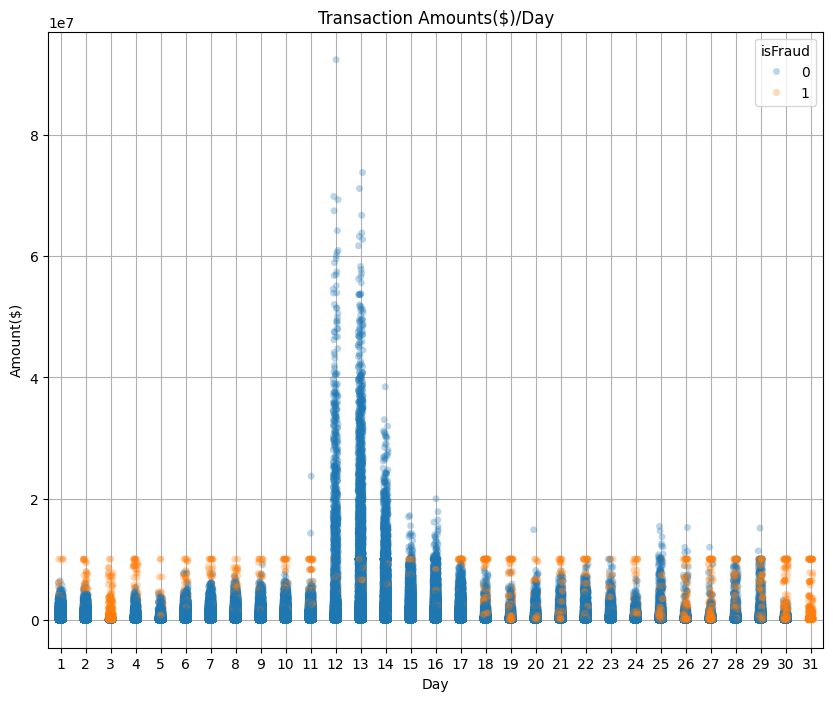

In [18]:
# Strip plot (Seaborn) of transaction amounts/day colour-coded by class

fig, ax = subplots(figsize=(10,8))

stripplot(x=fraud_df['Day'], y=fraud_df['amount'], hue=fraud_df['isFraud'], jitter=True, alpha=0.3)
ax.set_title('Transaction Amounts($)/Day')
ax.set_ylabel('Amount($)')
ax.grid(True)
show();

Fraud is limited to $10 million. Although fraud happens regularly,<br>
Days 3 & 31 (low transaction days) have a high proportion of fraudulent transactions of the 'cash out' and 'transfer' type. 

In [19]:
# Inspect 'type' feature

# Unsorted .value_counts()
type_counts = fraud_df['type'].value_counts(sort=False)  # Set sort=False so 'type_counts' will match 'type_labels' returned by .unique(), below
print(type_counts)
type_labels = fraud_df['type'].unique()

# Or sorted .value_counts(). But labels must be made manually to match! Pie chart info easier to digest (pun intented!).
type_counts = fraud_df['type'].value_counts()  # sort=True by default 
print(type_counts)
type_labels = ['CASH_OUT', 'PAYMENT', 'CASH_IN', 'TRANSFER', 'DEBIT']

type
PAYMENT     2151495
TRANSFER     532909
CASH_OUT    2237500
DEBIT         41432
CASH_IN     1399284
Name: count, dtype: int64
type
CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: count, dtype: int64


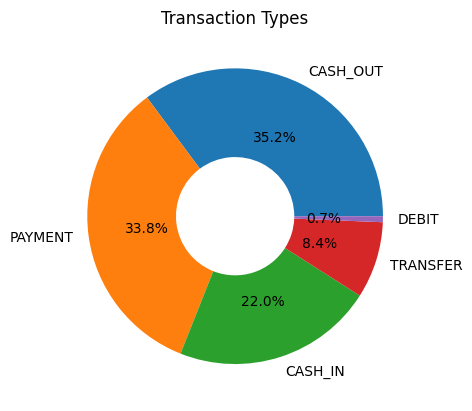

In [20]:
fig, ax = subplots()

ax.pie(x=type_counts, labels=type_labels, wedgeprops=dict(width=0.6), autopct='%1.1f%%')
ax.set_title('Transaction Types')

show()

In [21]:
# One Hot Encode 'type'

ohe = OneHotEncoder(sparse_output=False)

ohe_type = ohe.fit_transform(fraud_df[['type']])
# print(ohe_type)

# Verify OHE outcome
ohe_type_df = DataFrame(ohe_type, columns=ohe.categories_[0])  # [0] gets rid of brackets & commas from the feature names
ohe_type_df

,CASH_IN,CASH_OUT,DEBIT,PAYMENT,TRANSFER
0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,0.0,1.0
3,0.0,1.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...
6362615,0.0,1.0,0.0,0.0,0.0
6362616,0.0,0.0,0.0,0.0,1.0
6362617,0.0,1.0,0.0,0.0,0.0
6362618,0.0,0.0,0.0,0.0,1.0


In [22]:
# Concatenate fraud_df & ohe_type_df and drop 'type' feature

new_fraud_df = concat([ohe_type_df, fraud_df], axis=1)
new_fraud_df.drop('type', axis=1, inplace=True)
new_fraud_df.head()

,CASH_IN,CASH_OUT,DEBIT,PAYMENT,TRANSFER,amount,nameOrig,oldbalanceOrig,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,Day
0,0.0,0.0,0.0,1.0,0.0,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,1
1,0.0,0.0,0.0,1.0,0.0,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,1
2,0.0,0.0,0.0,0.0,1.0,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,1
3,0.0,1.0,0.0,0.0,0.0,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,1
4,0.0,0.0,0.0,1.0,0.0,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,1


In [23]:
# Transaction types by class

new_fraud_df.groupby('isFraud').describe()

CASH_IN                                                CASH_OUT  \
             count      mean       std  min  25%  50%  75%  max      count   
isFraud                                                                      
0        6354407.0  0.220207  0.414386  0.0  0.0  0.0  0.0  1.0  6354407.0   
1           8213.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0     8213.0   

                                                          DEBIT           \
             mean       std  min  25%  50%  75%  max      count     mean   
isFraud                                                                    
0        0.351470  0.477429  0.0  0.0  0.0  1.0  1.0  6354407.0  0.00652   
1        0.501157  0.500029  0.0  0.0  1.0  1.0  1.0     8213.0  0.00000   

                                              PAYMENT                      \
              std  min  25%  50%  75%  max      count      mean       std   
isFraud                                                                     
0        0.080484  0.0  0.0  0.0  0.0  1.0  6354407.0  0.338583  0.473228   
1        0.000000  0.0  0.0  0.0  0.0  0.0     8213.0  0.000000  0.000000   

                                   TRANSFER                                \
         min  25%  50%  75%  max      count      mean       std  min  25%   
isFraud                                                                     
0        0.0  0.0  0.0  1.0  1.0  6354407.0  0.083220  0.276214  0.0  0.0   
1        0.0  0.0  0.0  0.0  0.0     8213.0  0.498843  0.500029  0.0  0.0   

                           amount                                    \
         50%  75%  max      count          mean           std   min   
isFraud                                                               
0        0.0  0.0  1.0  6354407.0  1.781970e+05  5.962370e+05  0.01   
1        0.0  1.0  1.0     8213.0  1.467967e+06  2.404253e+06  0.00   

                                                        oldbalanceOrig  \
                25%        50%         75%          max          count   
isFraud                                                                  
0         13368.395   74684.72   208364.76  92445516.64      6354407.0   
1        127091.330  441423.44  1517771.48  10000000.00         8213.0   

                                                                            \
                 mean           std  min        25%        50%         75%   
isFraud                                                                      
0        8.328287e+05  2.887144e+06  0.0       0.00   14069.00   106969.50   
1        1.649668e+06  3.547719e+06  0.0  125822.44  438983.45  1517771.48   

                     newbalanceOrig                                         \
                 max          count           mean           std  min  25%   
isFraud                                                                      
0        43818855.30      6354407.0  855970.228109  2.924987e+06  0.0  0.0   
1        59585040.37         8213.0  192392.631836  1.965666e+06  0.0  0.0   

                                     oldbalanceDest                \
         50%        75%          max          count          mean   
isFraud                                                             
0        0.0  144730.74  43686616.33      6354407.0  1.101421e+06   
1        0.0       0.00  49585040.37         8213.0  5.442496e+05   

                                                                    \
                  std  min  25%       50%        75%           max   
isFraud                                                              
0        3.399202e+06  0.0  0.0  133311.8  944144.58  3.560159e+08   
1        3.336421e+06  0.0  0.0       0.0  147828.66  2.362305e+08   

        newbalanceDest                                                   \
                 count          mean           std  min  25%        50%   
isFraud                                                                   
0            6354407.0  1.224926e+06

### Fraudulent transactions are only in 'cash out' and 'transfer' (mean != 0 for class 1)!

# Correlation Analyses

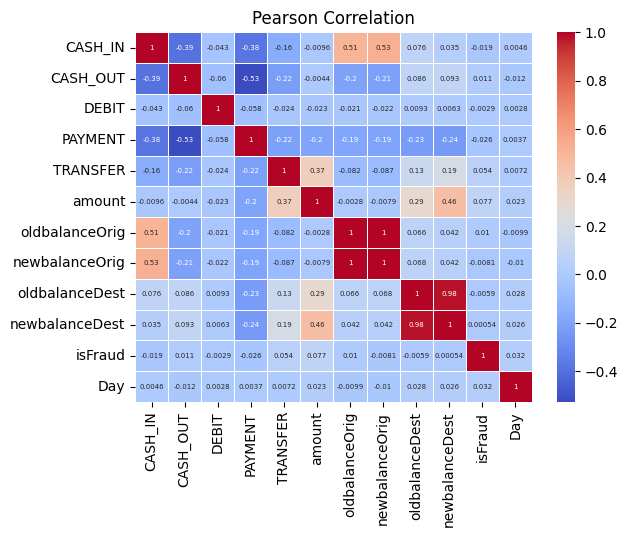

In [24]:
# Pearson correlation

pc_mat = new_fraud_df.corr(method='pearson', numeric_only=True)

fig, ax = subplots()

heatmap(pc_mat, annot=True, annot_kws={'fontsize':5}, linewidths=0.5, cmap='coolwarm')
ax.set_title('Pearson Correlation')

show()

In [25]:
# Seaborn pairwise plot of features

# pairplot(new_fraud_df, hue='isFraud', diag_kind='kde', corner=True)

# show()

# Inspect classes

In [26]:
print(new_fraud_df['isFraud'].value_counts())
new_fraud_df['isFraud'].value_counts(normalize=True)

isFraud
0    6354407
1       8213
Name: count, dtype: int64


isFraud
0    0.998709
1    0.001291
Name: proportion, dtype: float64

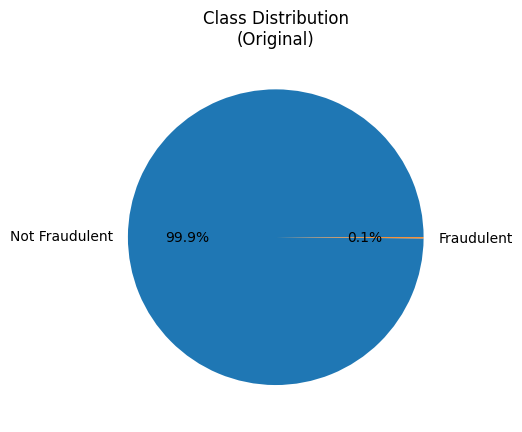

In [27]:
# Class distribution

isFraud_labels = ['Not Fraudulent', 'Fraudulent']  # [0, 1]
isFraud_counts = new_fraud_df['isFraud'].value_counts()

fig, ax = subplots()

ax.pie(x=isFraud_counts, labels=isFraud_labels, autopct='%1.1f%%')
ax.set_title(f'Class Distribution\n(Original)')

show()

Only 0.1% transactions are fraudulent. This is good, but such imbalance may be an issue for ML modelling (biasing class 0/not fraudulent).<br>
Given the very large dataset (>6.3e6), consider undersampling (for the sake of my CPU).<br>
Rebalancing the classes to 50/50 (1:1) is unrealistic and likely lead to some under/overfitting.<br>
The '0':'1' class ratio is 774:1.<br>
To preserve 'authenticity' of dataset, won't balance classes [0, 1] 1:1. Instead try 10:1, 100:1.

In [28]:
X_df = new_fraud_df.drop(['isFraud'], axis=1)
X = X_df.to_numpy()

y_df = new_fraud_df['isFraud']
y = y_df.to_numpy()

In [29]:
print(Counter(y_df))  # Original class split
RS = 962

# Random undersampling majority class 0
# sample_strat = 'majority'  # Random undersampling majority class 0 to match minority class 1 (i.e., from 774:1 to 50/50 (or more correctly 1:1))
# sample_strat = 0.01  # Random undersampling majority class 0 from 774:1 to 100:1
sample_strat = 0.1  # Random undersampling majority class 0 from 774:1 to 10:1
# sample_strat = 0.2  # Random undersampling majority class 0 from 774:1 to 5:1
# sample_strat = 0.3  # Random undersampling majority class 0 from 774:1 to 3.3:1
# sample_strat = 0.4  # Random undersampling majority class 0 from 774:1 to 2.5:1
# sample_strat = 0.5  # Random undersampling majority class 0 from 774:1 to 2:1

rus = RandomUnderSampler(sampling_strategy=sample_strat, random_state=RS)

X_rus, y_rus = rus.fit_resample(X_df, y_df)  # Class split after undersampling
Counter(y_rus)

Counter({0: 6354407, 1: 8213})


Counter({0: 82130, 1: 8213})

Index(['CASH_IN', 'CASH_OUT', 'DEBIT', 'PAYMENT', 'TRANSFER', 'amount',
       'nameOrig', 'oldbalanceOrig', 'newbalanceOrig', 'nameDest',
       'oldbalanceDest', 'newbalanceDest', 'Day', 'isFraud'],
      dtype='object')
(90343, 14)


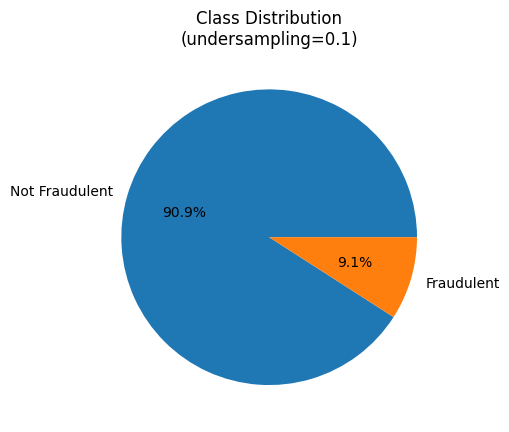

In [30]:
rus_df = concat([X_rus, y_rus], axis=1)
print(rus_df.columns)
print(rus_df.shape)


isFraud_labels = ['Not Fraudulent', 'Fraudulent']  # [0, 1]
isFraud_counts = rus_df['isFraud'].value_counts()

fig, ax = subplots()

ax.pie(x=isFraud_counts, labels=isFraud_labels, autopct='%1.1f%%')
ax.set_title(f'Class Distribution\n(undersampling={sample_strat})')

show()

In [31]:
# Seaborn pairwise plot of features

# pairplot(rus_df, hue='isFraud', diag_kind='kde', corner=True)

# show()

In [32]:
# Inspect categorical features

print(rus_df['nameOrig'].nunique())
rus_df['nameDest'].nunique()

90340


84695

In [33]:
# Drop 'nameOrig' and 'nameDest'. I am not tempted to one hot encode 10,000s categories!

rus_df.drop(['nameOrig', 'nameDest'], axis=1, inplace=True)


In [34]:
#Verify outcome of .drop()
print(rus_df.shape)
print(rus_df.columns)
rus_df.head()

(90343, 12)
Index(['CASH_IN', 'CASH_OUT', 'DEBIT', 'PAYMENT', 'TRANSFER', 'amount',
       'oldbalanceOrig', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest',
       'Day', 'isFraud'],
      dtype='object')


,CASH_IN,CASH_OUT,DEBIT,PAYMENT,TRANSFER,amount,oldbalanceOrig,newbalanceOrig,oldbalanceDest,newbalanceDest,Day,isFraud
855570,1.0,0.0,0.0,0.0,0.0,398126.07,136760.00,534886.07,135871.10,0.00,2,0
1036919,0.0,0.0,0.0,1.0,0.0,6704.97,10654.00,3949.03,0.00,0.00,4,0
2986664,1.0,0.0,0.0,0.0,0.0,14009.47,3306855.93,3320865.40,200913.85,186904.38,10,0
1210236,0.0,1.0,0.0,0.0,0.0,7543.12,328817.00,321273.88,903948.55,911491.66,6,0
1572680,0.0,0.0,0.0,1.0,0.0,11995.39,20811.00,8815.61,0.00,0.00,7,0


After preprocessing, reduced number of samples from 6,362,620 to 90,343 but increased features from 10 to 12.

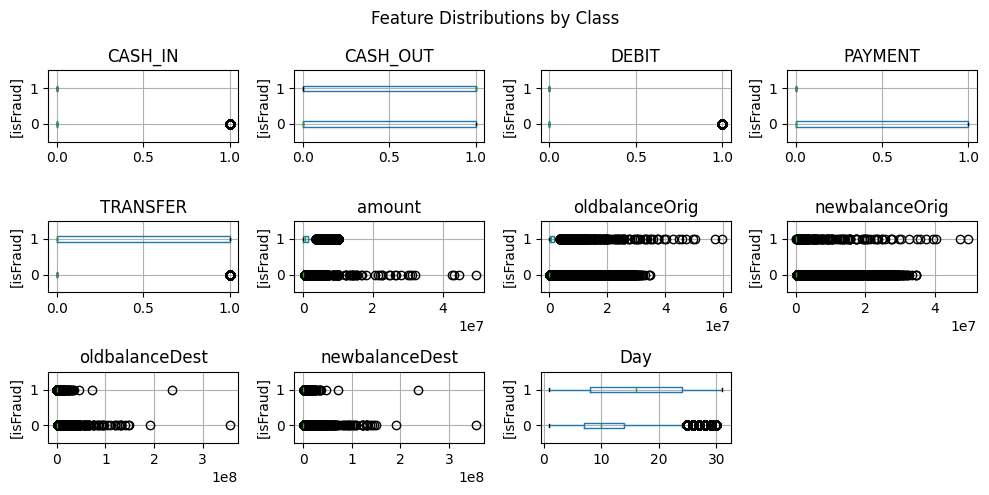

In [35]:
# Boxplot inspection of feature distribution by class

X_df = rus_df.drop(columns='isFraud')  # Dataframe of only features, excluding 'isFraud' class

n_rows = 3
n_cols = 4
fig, axes = subplots(nrows=n_rows, ncols=n_cols, figsize=(10,5))

for col, ax in zip(X_df, axes.ravel()):
    rus_df[[col, 'isFraud']].boxplot(vert=False, by='isFraud', ax=ax)
    # ax.set_ylabel('')  # Suppress y-label

axes[2,3].axis('off')  # Hide unused axis

fig.suptitle('Feature Distributions by Class')
fig.tight_layout()

show()

### Confirmation that only transaction types 'cash out' and 'transfer' are fraudulent!<br>
There are heaps of 'outliers'.<br>
The data ranges differ by up to 8 orders of magnitude, so would benefit from scaling (for some ML algorithms).

# Define X & y datasets

In [36]:
# X_df already defined above

X = X_df.to_numpy()
print(X.shape)

y_df = rus_df['isFraud']
y = y_df.to_numpy()
print(y.shape)


(90343, 11)
(90343,)


# Split data

In [37]:
# Train Test Split

RS = 962

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=RS)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(72274, 11) (18069, 11) (72274,) (18069,)


# Scale

In [38]:
rob_scl = RobustScaler()
std_scl = StandardScaler()

# X_train_scaled = rob_scl.fit_transform(X_train)
X_train_scaled = std_scl.fit_transform(X_train)
print(X_train_scaled)

# X_test_scaled = rob_scl.transform(X_test)
X_test_scaled = std_scl.transform(X_test)
print(X_test_scaled)

[[-0.50024212 -0.75481168 -0.07808471 ... -0.29820161 -0.32075235
   0.77628559]
 [-0.50024212 -0.75481168 -0.07808471 ... -0.29820161 -0.32075235
   0.93127208]
 [-0.50024212  1.32483377 -0.07808471 ... -0.12306163 -0.09563134
  -0.30861985]
 ...
 [-0.50024212  1.32483377 -0.07808471 ... -0.28990903 -0.28583074
  -1.23853879]
 [ 1.99903198 -0.75481168 -0.07808471 ...  0.30047655  0.21537419
  -0.61859283]
 [-0.50024212 -0.75481168 -0.07808471 ... -0.29820161 -0.32075235
   0.77628559]]
[[ 1.99903198 -0.75481168 -0.07808471 ...  0.45575449  0.3607885
   0.31132612]
 [ 1.99903198 -0.75481168 -0.07808471 ... -0.29820161 -0.32075235
  -0.30861985]
 [-0.50024212  1.32483377 -0.07808471 ... -0.25927534  0.11557897
   3.10108295]
 ...
 [-0.50024212 -0.75481168 -0.07808471 ... -0.29820161 -0.32075235
  -1.54851177]
 [-0.50024212  1.32483377 -0.07808471 ... -0.25530674 -0.26077933
   0.31132612]
 [-0.50024212  1.32483377 -0.07808471 ... -0.29820161 -0.05708595
   2.3261505 ]]


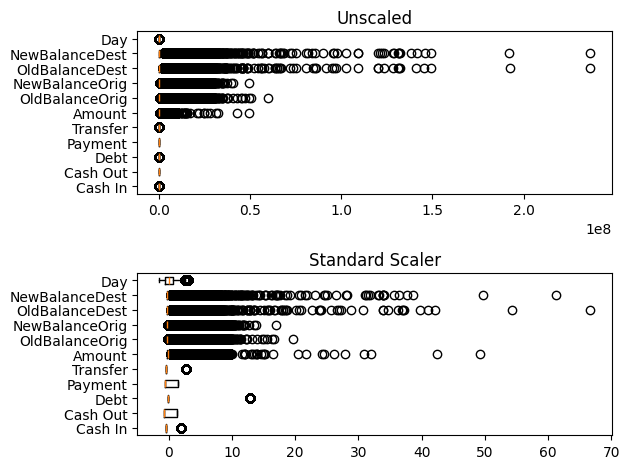

In [39]:
# Inspect scaling effect

n_rows = 2
n_cols = 1
y_labels = ['Cash In', 'Cash Out', 'Debt', 'Payment', 'Transfer', 'Amount', 'OldBalanceOrig', 'NewBalanceOrig', 'OldBalanceDest', 'NewBalanceDest', 'Day']

fig, ax = subplots(nrows=n_rows, ncols=n_cols)

ax[0].boxplot(X_train, vert=False)
ax[0].set_yticklabels(y_labels)
ax[0].set_title('Unscaled')

ax[1].boxplot(X_train_scaled, vert=False)
ax[1].set_yticklabels(y_labels)
# ax[1].set_title('Robust Scaler')
ax[1].set_title('Standard Scaler')

fig.tight_layout()

show()

# Supervised ML Modelling

In [40]:
# Explore 6 classifiers

RS = 962

classifiers = {'Random Forest': RandomForestClassifier(random_state=RS, n_jobs=-1),
               'Gradient Boost': GradientBoostingClassifier(random_state=RS),
               'Decision Tree': DecisionTreeClassifier(criterion='gini', random_state=RS),
               'SVC (RBF)': SVC(kernel='rbf', random_state=RS),
               'SVC (Lin)': SVC(kernel='linear', random_state=RS),
               'Logistic Regression': LogisticRegression(max_iter=1000, random_state=RS, n_jobs=-1)}

In [41]:
# Cross Validation (Stratified Shuffle Split)

n_splits = 5
train_size = 0.8
sss = StratifiedShuffleSplit(n_splits=n_splits, train_size=train_size, random_state=RS)

In [42]:
# Scale X data after splitting

scores_clf = []  # List for classifiers' scores; NB: some clfs, such as RandomForest, do not have accuracy_score, so use 'score' instead
recall_clf = []  # List for classifiers' recall scores
precision_clf = []  # List for classifiers' precision scores
for train_ind, test_ind in sss.split(X, y):  # .split() returns indices for the train and test sample splits
    X_train = X[train_ind, :]  # train_ind = indices of rows used for training
    # X_train = rob_scl.fit_transform(X_train)  # Scale the training data
    X_train = std_scl.fit_transform(X_train)  # Scale the training data

    X_test = X[test_ind, :]  # test_ind = indices of rows used for testing
    # X_test = rob_scl.transform(X_test)  # Transform the test data with the fitted median and quartiles
    X_test = std_scl.transform(X_test)  # Transform the test data with the fitted median and quartiles
    
    y_train = y[train_ind]
    y_test = y[test_ind]

    scores_splits = []  # List of split scores for each classifier
    recall_splits = []  # List of split recall scores for each classifier
    precision_splits = []  # List of split precision scores for each classifier
    for name, clf in classifiers.items():
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)

        recall_splits.append(recall_score(y_test, y_pred, pos_label=0))  # Set the positive label = 0(malignant). Calculates the recall scores for each of the classifiers using the same X_test and y_test splits, and appends to list
        precision_splits.append(precision_score(y_test, y_pred))  # Calculates the precision scores for each of the classifiers using the same X_test and y_test splits, and appends to list
        scores_splits.append(clf.score(X_test, y_test))  # Calculates the scores for each of the classifiers using the same X_test and y_test splits, and appends to list

    recall_clf.append(recall_splits)  # Appends all classifiers' recall scores for the same X_test and y_test splits
    precision_clf.append(precision_splits)  # Appends all classifiers' precision scores for the same X_test and y_test splits
    scores_clf.append(scores_splits)  # Appends all classifiers' scores for the same X_test and y_test splits

recall_mean = round(mean(recall_clf, axis=0) * 100, 1)  # axis=0: calculate mean recall scores of columns/classifier
precision_mean = round(mean(precision_clf, axis=0) * 100, 1)  # axis=0: calculate mean precision scores of columns/classifier
scores_mean = round(mean(scores_clf, axis=0) * 100, 1)  # axis=0: calculate mean scores of columns/classifier


In [43]:
# Sneak-Peek at model metrics

print(recall_mean)
print(precision_mean)
print(scores_mean)

[99.8 99.7 99.8 99.4 99.7 99.7]
[97.9 97.3 97.7 92.  96.6 96.3]
[99.5 99.2 99.6 97.1 97.3 97.1]


Noice!

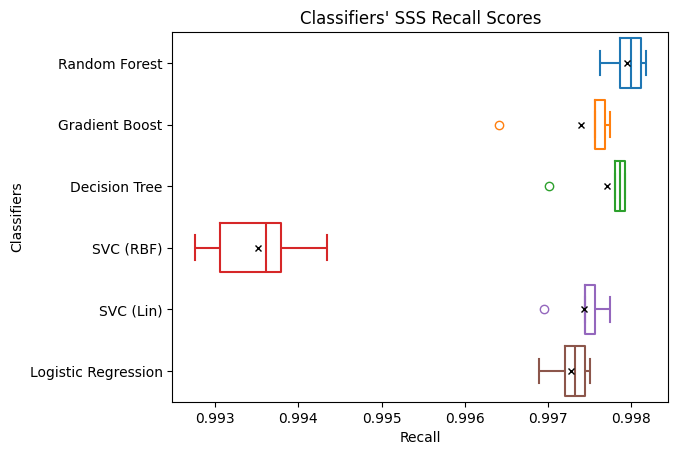

In [44]:
# Boxplot (Seaborne) of classifiers' recall scores resulting from Stratified Shuffle Split

# Convert list to Pandas Dataframe for Seaborne
recall_clf_df = DataFrame(recall_clf, columns=[name for name in classifiers.keys()])

fig, ax = subplots()

boxplot(data=recall_clf_df, orient='h', fill=False, showmeans=True, meanprops={'marker':'x',
                                                                                'markeredgecolor':'k',
                                                                                'markersize':'5'})
ax.set_title("Classifiers' SSS Recall Scores")
ax.set_xlabel('Recall')
ax.set_ylabel('Classifiers')

show()

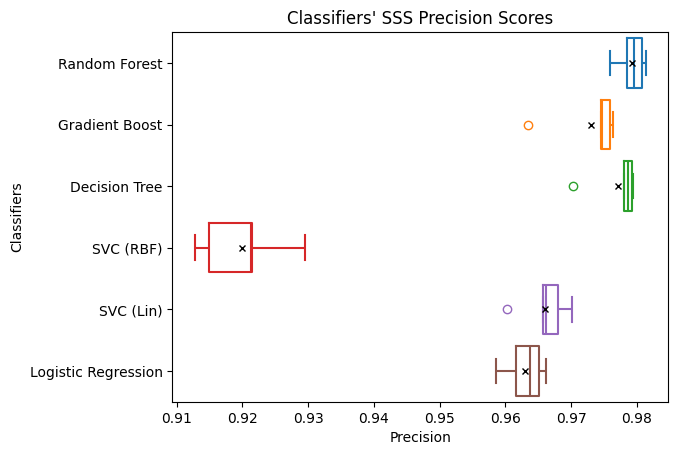

In [45]:
# Boxplot (Seaborne) of classifiers' precision scores resulting from Stratified Shuffle Split

# Convert list to Pandas Dataframe for Seaborne
precision_clf_df = DataFrame(precision_clf, columns=[name for name in classifiers.keys()])

fig, ax = subplots()

boxplot(data=precision_clf_df, orient='h', fill=False, showmeans=True, meanprops={'marker':'x',
                                                                                'markeredgecolor':'k',
                                                                                'markersize':'5'})
ax.set_title("Classifiers' SSS Precision Scores")
ax.set_xlabel('Precision')
ax.set_ylabel('Classifiers')

show()

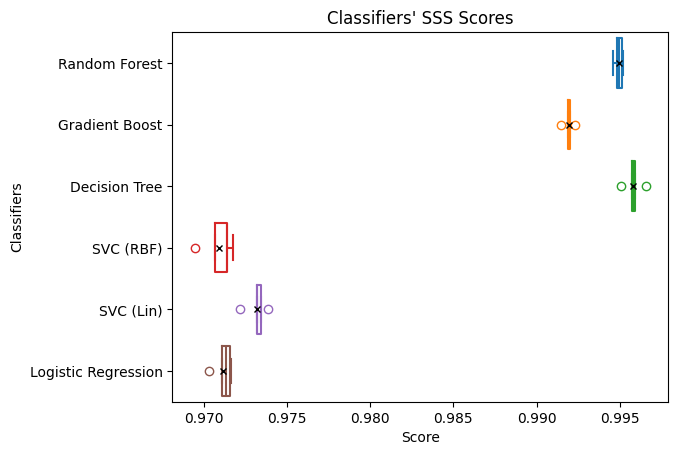

In [46]:
# Boxplot (Seaborne) of classifiers' scores resulting from Stratified Shuffle Split

# Convert list to Pandas Dataframe for Seaborne
scores_clf_df = DataFrame(scores_clf, columns=[name for name in classifiers.keys()])

fig, ax = subplots()

boxplot(data=scores_clf_df, orient='h', fill=False, showmeans=True, meanprops={'marker':'x',
                                                                                'markeredgecolor':'k',
                                                                                'markersize':'5'})
ax.set_title("Classifiers' SSS Scores")
ax.set_xlabel('Score')
ax.set_ylabel('Classifiers')

show()

Five fold stratified shuffle split (n_splits) results in tight scores without being too computationally expensive.

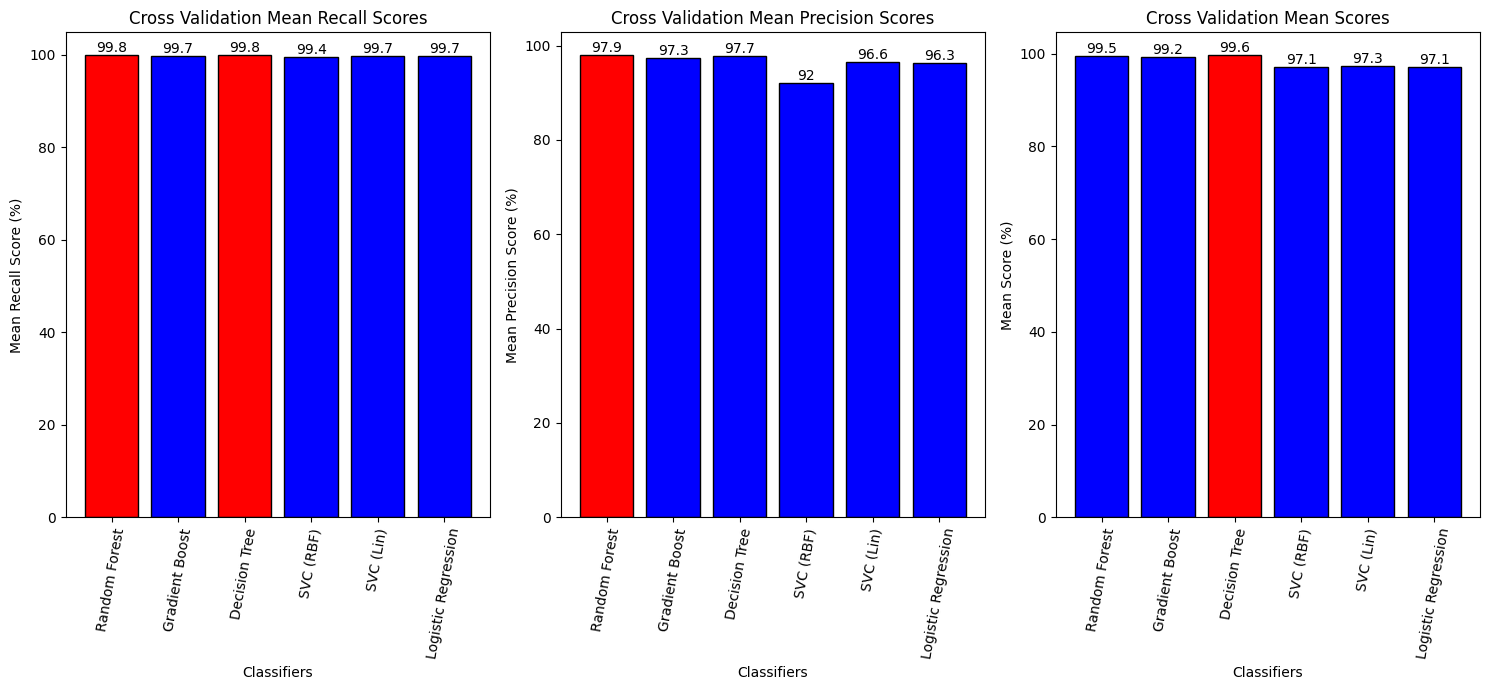

In [47]:
# PLot classifiers' mean scores resulting from Stratified Shuffle Split

plt_labels = list(classifiers.keys())  # Create a list of classifier names from the dictionary keys to be used as plot labels
xticks = arange(len(classifiers.keys()))  # Specify the number of x-ticks

recall_colour = ['r' if (bar == max(recall_mean)) else 'b' for bar in recall_mean]  # Colour the highest mean recall score red
precision_colour = ['r' if (bar == max(precision_mean)) else 'b' for bar in precision_mean]  # Colour the highest mean precision score red
score_colour = ['r' if (bar == max(scores_mean)) else 'b' for bar in scores_mean]  # Colour the highest mean score red

fig, ax = subplots(ncols=3, figsize=(15, 7))

recall_bar_con = ax[0].bar(x=xticks, height=recall_mean, tick_label=plt_labels, color=recall_colour, edgecolor='k')  # Create a bar container to label the bars with the scores
ax[0].bar_label(recall_bar_con)  # .bar_label() uses the the data values (i.e., height=) from the container (bar_con) as labels
ax[0].set_ylabel('Mean Recall Score (%)')
ax[0].set_xlabel('Classifiers')
ax[0].set_xticklabels(plt_labels, rotation=80)
ax[0].set_title("Cross Validation Mean Recall Scores")

precision_bar_con = ax[1].bar(x=xticks, height=precision_mean, tick_label=plt_labels, color=precision_colour, edgecolor='k')  # Create a bar container to label the bars with the scores
ax[1].bar_label(precision_bar_con)  # .bar_label() uses the the data values (i.e., height=) from the container (bar_con) as labels
ax[1].set_ylabel('Mean Precision Score (%)')
ax[1].set_xlabel('Classifiers')
ax[1].set_xticklabels(plt_labels, rotation=80)
ax[1].set_title("Cross Validation Mean Precision Scores")

score_bar_con = ax[2].bar(x=xticks, height=scores_mean, tick_label=plt_labels, color=score_colour, edgecolor='k')  # Create a bar container to label the bars with the scores
ax[2].bar_label(score_bar_con)  # .bar_label() uses the the data values (i.e., height=) from the container (bar_con) as labels
ax[2].set_ylabel('Mean Score (%)')
ax[2].set_xlabel('Classifiers')
ax[2].set_xticklabels(plt_labels, rotation=80)
ax[2].set_title("Cross Validation Mean Scores")

fig.tight_layout()

show()

High performance from all models.

# Confusion Matrix

In [48]:
# Plot Confusion Matrix

def plot_confusion_matrix(y_true, y_pred, classes, normalize=True, ax=None):
    """
    This function prints/plots the confusion matrix (adapted from a SciKit-Learn example)

    y_true: Actual class labels (array)
    y_pred: Predicted class labels (array)
    classes: Class names (str, array)
    normalize: Normalize the results (True), or show as integer values (False)
    ax: Visualization axis
    """

    from itertools import product
    from numpy import asarray, newaxis
    from sklearn.metrics import confusion_matrix

    cm = confusion_matrix(y_true, y_pred)
    n_classes = len(classes)

    if normalize:
        cm = asarray(cm).astype('float32') /cm.sum(axis=1)[:, newaxis]

    if not ax:
        from matplotlib.pyplot import subplots, show
        fig, ax = subplots()

    ticks = range(n_classes)
    ax.imshow(cm, interpolation='nearest', cmap='Blues')
    ax.set_xticks(ticks)
    ax.set_xticklabels(classes, rotation=90)
    ax.set_yticks(ticks)
    ax.set_yticklabels(classes)
    fmt = '.2f' if normalize else 'd'
    thresh = 3*cm.max() / 4
    cm_dim = cm.shape

    # Matrix indices:
    indices_a = range(cm_dim[0])
    indices_b = range(cm_dim[1])
    # Cartesian product of matrix indices:
    indices = product(indices_a, indices_b)
    fmt = '.3f' if normalize else 'd'

    for ind_a, ind_b in indices:
      label = format(cm[ind_a, ind_b], fmt)
      color = "white" if cm[ind_a, ind_b] > thresh else "black"
      ax.text(ind_b, ind_a, label, ha="center", color=color)
    ax.set_ylabel('True Labels')
    ax.set_xlabel('Predicted Labels')

    return ax

In [49]:
# Split training and test data and scale X data

train_size = 0.8
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size, random_state=RS, shuffle=True)
X_train_scaled = std_scl.fit_transform(X_train)
X_test_scaled = std_scl.transform(X_test)

print(X.shape, X_train_scaled.shape, X_test_scaled.shape, y_train.shape, y_test.shape)

(90343, 11) (72274, 11) (18069, 11) (72274,) (18069,)


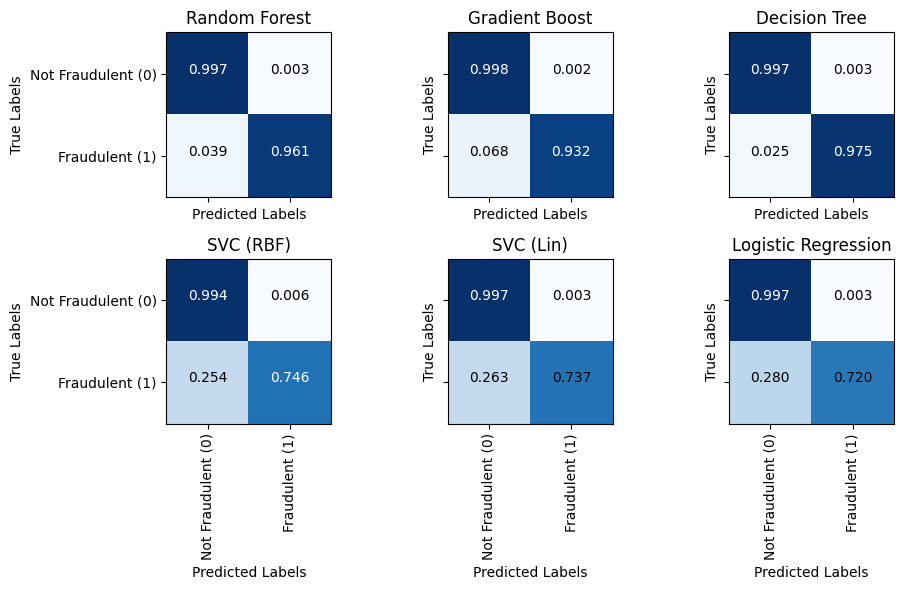

In [50]:
# Confusion matrix evaluation

class_names = ('Not Fraudulent (0)', 'Fraudulent (1)')
n_rows = 2
n_cols = 3

fig, axes = subplots(figsize=(10, 6), ncols=n_cols, nrows=n_rows, sharey=True, sharex=True)

for ax, (name, clf) in zip(axes.ravel(), classifiers.items()):
    clf.fit(X_train_scaled, y_train)  # Fit with training data
    y_pred = clf.predict(X_test_scaled)  # Predict class labels using test data

    plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True, ax=ax)
    ax.set_title(name, fontsize=12)

fig.tight_layout()

show()

RF/GB/DT score better especially for fewer false negatives.

# ROC-AUC

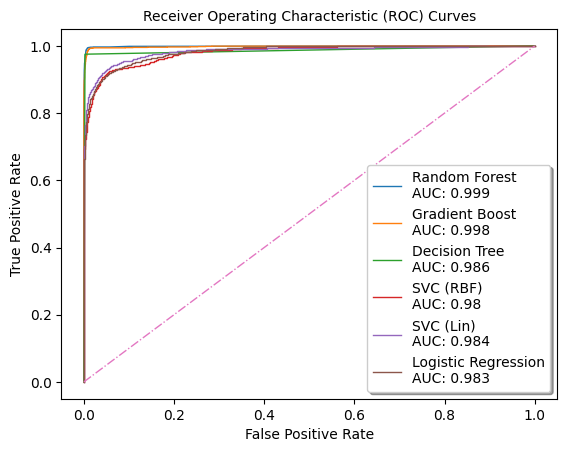

In [51]:
# ROC AUC evaluation
# A more comprehensive picture of TPR v FPR (considering all thresholds of Confusion Matrix)

fig, ax = subplots()

for name, clf in classifiers.items():
    clf.fit(X_train_scaled, y_train)

    # Checking whether or not the object has 'decision_function':
    if hasattr(clf, 'decision_function'):  # If it does...
        y_score = clf.decision_function(X_test_scaled)
    else:
        y_score = clf.predict_proba(X_test_scaled)[:, 1]  # We only need probabilities for one column.

    # Obtaining the x- and y-axis values for the ROC curve:
    fpr, tpr, thresh = roc_curve(y_test, y_score)

    # Obtaining the AUC value:
    roc_auc = roc_auc_score(y_test, y_score)

    ax.plot(fpr, tpr, lw=1, label = f'{name}\nAUC: {round(roc_auc, 3)}')

ax.plot([0, 1], [0, 1], lw=1, linestyle='-.') 
ax.set_title('Receiver Operating Characteristic (ROC) Curves', fontsize=10)
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.legend(ncols=1, fontsize=10, shadow=True)

show()

RF/GB/DT perform better (marginally), as expected from the confusion matrix results.

# Feature Importance

In [52]:
# Feature Importances of Top Ensemble and Tree Classifiers

classifiers_top = {'Random Forest': RandomForestClassifier(random_state=RS, n_jobs=-1),
               'Gradient Boost': GradientBoostingClassifier(random_state=RS),
               'Decision Tree': DecisionTreeClassifier(criterion='gini', random_state=RS)}

In [53]:
# Feature Importance

feat_imp = []
# for ax, (name, clf) in zip(axes.ravel(), classifiers_top.items()):
for name, clf in classifiers_top.items():
    clf.fit(X_train_scaled, y_train)  # Fit with training data
    fi = clf.feature_importances_.tolist()  # Extract feature importances to list
    feat_imp.append(fi)
    print(name, fi)


Random Forest [0.014815756448684034, 0.030503913088537185, 0.00012551244899585768, 0.017035403009880084, 0.0906354154523129, 0.19785861003598462, 0.24480533212467623, 0.10074320560860554, 0.07065810768794936, 0.15015896319501804, 0.08265978089935616]
Gradient Boost [0.007691326885134804, 0.021941339622380013, 0.0, 0.005578448835500334, 0.08794774846695709, 0.21495899306235458, 0.28675147002374607, 0.15029674337478977, 0.0005503341360723485, 0.1775798529861526, 0.04670374260691247]
Decision Tree [0.0037388940018308115, 0.03568082932618207, 0.0, 0.0, 0.08785092296845255, 0.2694821025899114, 0.3208820169767627, 0.05539710054201914, 0.005505329715946739, 0.20034650859627842, 0.021116295282616177]


In [54]:
# Extract feature importance for each model 

feat_imp_rf = feat_imp[0]
# print(feat_imp_rf)

feat_imp_gb = feat_imp[1]
# print(feat_imp_gb)

feat_imp_dt = feat_imp[2]
# print(feat_imp_dt)

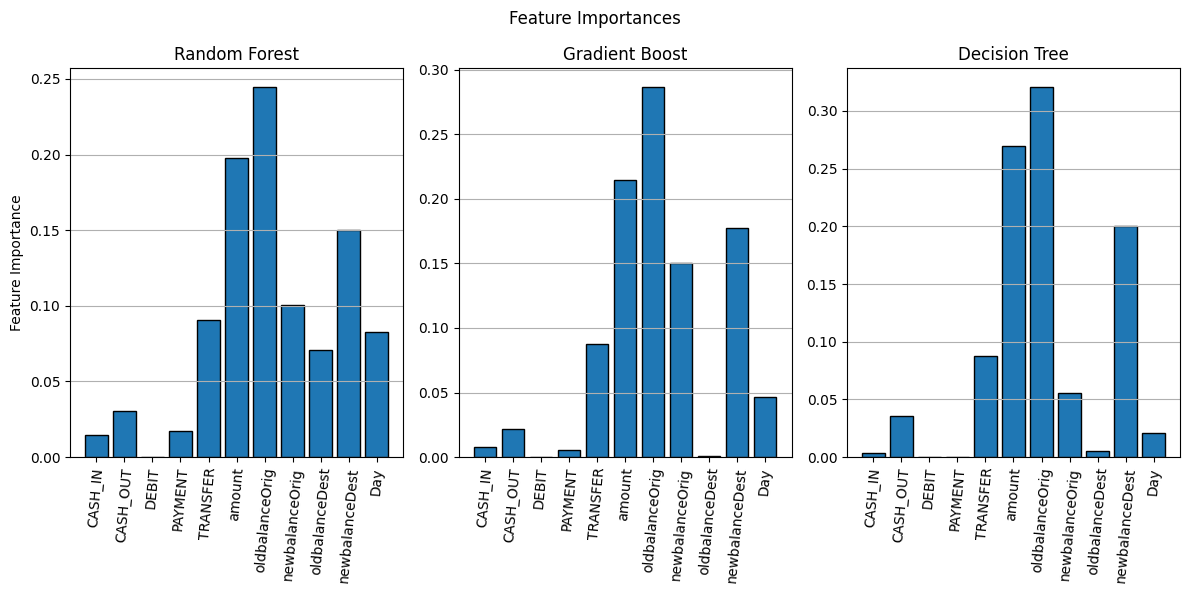

In [55]:
# Bar chart of feature importances

feat_names = X_df.columns.to_list()  # Create a list of feature names to be used as plot labels
xticks = arange(len(feat_names))  # Specify the number of x-ticks

n_rows = 1
n_cols = 3
fig, ax = subplots(nrows=n_rows, ncols=n_cols, figsize=(12,6))

rf_bar_con = ax[0].bar(x=xticks, height=feat_imp_rf, tick_label=feat_names, edgecolor='k')  # Create a bar container to label the bars with the feature importnaces
# ax[0].bar_label(rf_bar_con)  # .bar_label() uses the the data values (i.e., height=) from the container (bar_con) as labels
ax[0].set_ylabel('Feature Importance')
ax[0].set_xticklabels(feat_names, rotation=85)
ax[0].grid(visible=True, axis='y')
ax[0].set_title('Random Forest')

gb_bar_con = ax[1].bar(x=xticks, height=feat_imp_gb, tick_label=feat_names, edgecolor='k')  # Create a bar container to label the bars with the feature importnaces
# ax[1].bar_label(gb_bar_con)  # .bar_label() uses the the data values (i.e., height=) from the container (bar_con) as labels
ax[1].set_xticklabels(feat_names, rotation=85)
ax[1].grid(visible=True, axis='y')
ax[1].set_title('Gradient Boost')

dt_bar_con = ax[2].bar(x=xticks, height=feat_imp_dt, tick_label=feat_names, edgecolor='k')  # Create a bar container to label the bars with the feature importnaces
# ax[2].bar_label(dt_bar_con)  # .bar_label() uses the the data values (i.e., height=) from the container (bar_con) as labels
ax[2].set_xticklabels(feat_names, rotation=85)
ax[2].grid(visible=True, axis='y')
ax[2].set_title('Decision Tree')

fig.suptitle('Feature Importances')
fig.tight_layout()

show()

'Amount', 'oldbalanceOrig' and 'newbalanceDest' are important features for each of these models.